### The model

$u(c) = log(c)$ utility function    
$y = 1$ Deterministic income    
$p(r = 0.02) = 0.5$   
$p(r = -0.01) = 0.5$ 

In [1]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# discounting factor 
beta = 0.95
# wealth level
eps = 0.001
w_low = eps
w_high = 10
# interest rate
r_up = 0.02
r_down = 0.01
# deterministic income
y = 1
# good state and bad state economy with equal probability 0.5
# with good investment return 0.02 or bad investment return -0.01
ws = np.linspace(w_low, w_high**(0.5),100)**2
Vs = np.zeros(100)
Cs = np.zeros(100)

def u(c):
    return np.log(c)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Value iteration
for j in range(30):
    if j % 10 == 0:
        print(j)
    for i in range(len(ws)):
        w = ws[i]
        def obj(c):
            return -(u(c) + beta*(np.interp((y+w-c)*(1+r_up), ws, Vs) + np.interp((y+w-c)*(1-r_down), ws, Vs))/2)
        bounds = [(eps, y+w-eps)]
        res = minimize(obj, eps, method='SLSQP', bounds=bounds)
        Cs[i] = res.x[0]
        Vs[i] = -res.fun

0
10
20


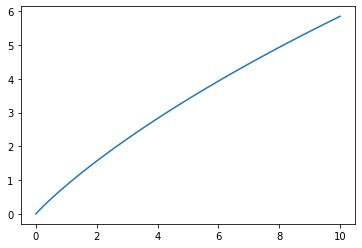

In [3]:
plt.plot(ws,Vs)

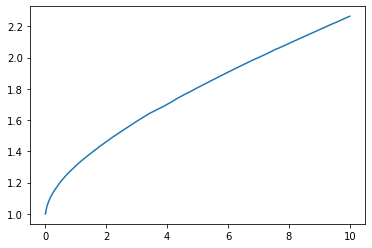

In [4]:
plt.plot(ws,Cs)

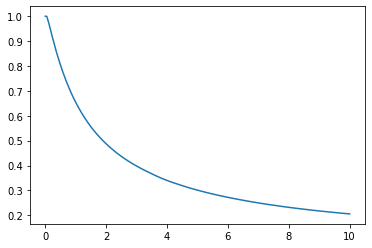

In [5]:
plt.plot(ws,Cs/(ws+y))

### policy gradient
Assume the policy form $\theta = (a,b, \sigma = 0.1)$, then $\pi_\theta$ ~ Beta($\alpha$, $\beta$)


Assume the initial value $a_1 = 0$, $b_1 = 0$, $c_1 = 0$, $d_1 = 0$, $a_2 = 0$, $b_2 = 0$, $c_2 = 0$, $d_2 = 0$:
$$\alpha = log(1+ e^{a_1 x^3 + b_1 x^2 + c_1 x + d_1}) + 1 $$
$$\beta = log(1+ e^{a_2 x^3 + b_2 x^2 + c_2 x + d_2}) + 1 $$


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [6]:
T = 100
def poly(the, w):
    return the[0]*(w**3) + the[1]*(w**2) +the[2]*w + the[3]

# simulation step T = 100
def a(theta, w):
    value = np.log(1+np.exp(poly(theta[:4],w))) + 1
    if isscalar(value):
        return max(min(value, 100),1)
    else:
        np.clip(value, 1, 100, out=value)
        return value

def b(theta, w):
    value = np.log(1+np.exp(poly(theta[4:],w))) + 1
    if isscalar(value):
        return max(min(value, 100),1)
    else:
        np.clip(value, 1, 100, out=value)
        return value


def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.uniform(w_low, w_high)
    for t in range(T):
        n = np.random.beta(a(theta, w), b(theta, w))
        n = max(min(n,1-eps),eps)
        c = n*(w+y)
        wPath[t] = w
        aPath[t] = n
        rPath[t] = u(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath

def gradientV(theta, D = 1000):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            newGrad[0] = np.sum(np.log(ap)*(wp**3)/(1+np.exp(-poly(theta[:4],wp))))
            newGrad[1] = np.sum(np.log(ap)*(wp**2)/(1+np.exp(-poly(theta[:4],wp))))
            newGrad[2] = np.sum(np.log(ap)*(wp)/(1+np.exp(-poly(theta[:4],wp))))
            newGrad[3] = np.sum(np.log(ap)*(1)/(1+np.exp(-poly(theta[:4],wp))))            
            
            newGrad[4] = np.sum(np.log(1-ap)*(wp**3)/(1+np.exp(-poly(theta[4:],wp))))
            newGrad[5] = np.sum(np.log(1-ap)*(wp**2)/(1+np.exp(-poly(theta[4:],wp))))
            newGrad[6] = np.sum(np.log(1-ap)*(wp)/(1+np.exp(-poly(theta[4:],wp))))
            newGrad[7] = np.sum(np.log(1-ap)*(1)/(1+np.exp(-poly(theta[4:],wp))))
                  
            grad += newGrad * np.sum(rp)
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta

def plot(theta):
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, a(theta,ws)/(a(theta,ws) + b(theta,ws))*(ws+y), 'r')

In [ ]:
# initial theta
N = 10000
theta = [0]*8
# gradient ascend step size 
alpha = 0.00001
# store theta
THETA = np.zeros((len(theta),N))
for i in range(N):
    if i%1 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA[:,i] = theta
    plot(theta)

0
[0, 0, 0, 0, 0, 0, 0, 0]
1
[0.00248497 0.00134306 0.0009263  0.00088353 0.00332355 0.00142759
 0.00092072 0.00086154]
2
[0.00504799 0.00257859 0.00174122 0.00164537 0.0061453  0.00266966
 0.00171705 0.00159766]
3
[0.00683598 0.00369522 0.00252926 0.00239679 0.00862274 0.00386878
 0.00250629 0.00233428]
4
[0.00863655 0.0048437  0.00333468 0.00315292 0.0110059  0.00507157
 0.00329767 0.00306339]
5
[0.0102767  0.00596078 0.00412569 0.00389713 0.01314979 0.00623051
 0.00407702 0.00378908]
6
[0.01173431 0.00701705 0.00489054 0.0046246  0.01524259 0.00736331
 0.00484015 0.00449488]
7
[0.01284846 0.00799744 0.00561508 0.00530703 0.01705976 0.00841519
 0.00555383 0.00515094]
8
[0.01449147 0.00909076 0.00637409 0.00600702 0.01902105 0.0095057
 0.00628374 0.00581848]
9
[0.01574008 0.010087   0.00709364 0.0066795  0.02077702 0.01054738
 0.00698894 0.00646252]
10
[0.01723884 0.01118346 0.00787513 0.00740615 0.02257296 0.0116525
 0.0077472  0.00715815]
11
[0.01829774 0.0121684  0.0086127  0.00810

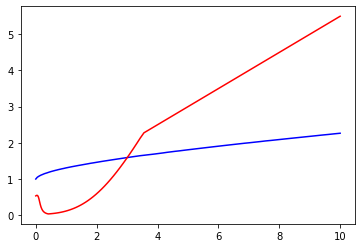

In [10]:
theta = [ 1.47743332e+00,  2.43328668e+00,  8.61027965e-01,  3.31450813e-01,
  1.39171541e+03,  1.92461647e+01, -9.65550056e-02, -9.59583824e-02]
plot(theta)

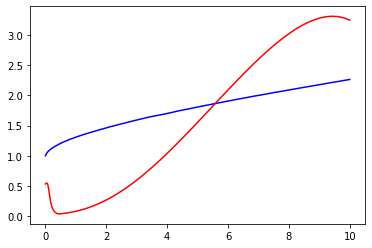

In [11]:
theta = [-1.72536529e-01,  2.05485382e+00,  7.67391291e-01,  3.04800928e-01,
  1.27333959e+03,  1.74656967e+01, -1.25344019e-01, -9.63860887e-02]
plot(theta)

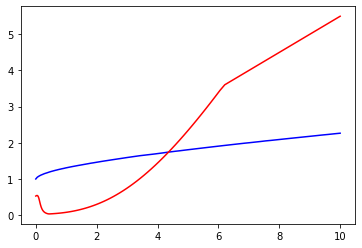

In [12]:
theta =[ 9.34663389e-02,  1.90208657e+00,  6.79459711e-01,  2.60837755e-01,
  1.24783360e+03,  1.72601005e+01, -1.07415560e-01, -9.38010551e-02]
plot(theta)

In [ ]:
# from scipy.stats import beta as B
# import matplotlib.pyplot as plt
# import numpy as np
# x = np.linspace(0, 1.0, 100)
# # for i in range(10):
# #     the = THETA[:,i]
# y = B.pdf(x, a(theta,10), b(theta,10))
# plt.plot(x, y)